# Fruits Image Classifier

## Imports

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.metrics import confusion_matrix, classification_report
import os
import shutil
from PIL import Image
from IPython.display import display, Image, clear_output
import ipywidgets as widgets
from collections import defaultdict
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

In [30]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Device configuration
# Apple silicon macbook MPS (Metal Performance Shaders)
device = torch.device('mps' if torch.mps.is_available else 'cpu')
print(f"Using device: {device}")

Using device: mps


## Hyperparameter Tweaking

In [32]:
# Hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.001
IMG_SIZE = 224
NUM_CLASSES = 4

## Data Preparation

### Rearrange project file structure for PyTorch's ImageFolder to work properly 
- Putting apple images into an apple folder and so on...

In [33]:
def organize_fruit_images(source_dir):
    """
    Organizes fruit images into class-specific folders based on their filenames.
    Keeps track of statistics and ensures safe file operations.
    """
    # First, let's create our class folders if they don't exist
    classes = ['apple', 'banana', 'orange', 'mixed']
    class_counts = defaultdict(int)

    # Create class directories
    for class_name in classes:
        class_dir = os.path.join(source_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
            print(f"Created directory: {class_dir}")

    # Process each image in the source directory
    for filename in os.listdir(source_dir):
        # Skip if not a jpg file or if it's a directory
        if not filename.endswith('.jpg') or os.path.isdir(os.path.join(source_dir, filename)):
            continue

        # Get the class from the filename (e.g., 'apple_1.jpg' -> 'apple')
        current_class = filename.split('_')[0]

        # Verify that it's one of our expected classes
        if current_class not in classes:
            print(f"Warning: Unexpected class in filename: {filename}")
            continue

        # Source and destination paths
        source_path = os.path.join(source_dir, filename)

        # Update the counter for this class
        class_counts[current_class] += 1
        new_filename = f"{current_class}_{class_counts[current_class]}.jpg"
        dest_path = os.path.join(source_dir, current_class, new_filename)

        # Move the file
        try:
            shutil.move(source_path, dest_path)
            print(f"Moved {filename} to {os.path.join(current_class, new_filename)}")
        except Exception as e:
            print(f"Error moving {filename}: {str(e)}")

    # Print summary statistics
    print("\nOrganization Complete!")
    print("\nFiles organized per class:")
    for class_name in classes:
        print(f"{class_name}: {class_counts[class_name]} images")

In [34]:
# Process both train and test directories
for directory in ['train', 'test']:
    print(f"\nProcessing {directory} directory...")
    organize_fruit_images(directory)


Processing train directory...

Organization Complete!

Files organized per class:
apple: 0 images
banana: 0 images
orange: 0 images
mixed: 0 images

Processing test directory...

Organization Complete!

Files organized per class:
apple: 0 images
banana: 0 images
orange: 0 images
mixed: 0 images


## Data Loading and Preprocessing Pipeline

### How to work with images?
- Make all images the same size
- Convert images into format that model can understand
- Create variations of images to help the model learn better and make the best of what we have currently

In [35]:
# Paths to dataset
train_dataset_path = '/Users/benben/workspace/Projects/NUS_Machine_Learning_Project/fruits-image-classifier/train'
test_dataset_path = '/Users/benben/workspace/Projects/NUS_Machine_Learning_Project/fruits-image-classifier/test'

In [36]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

In [37]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)
print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 240
    Root location: /Users/benben/workspace/Projects/NUS_Machine_Learning_Project/fruits-image-classifier/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset ImageFolder
    Number of datapoints: 60
    Root location: /Users/benben/workspace/Projects/NUS_Machine_Learning_Project/fruits-image-classifier/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTe

In [38]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(train_loader)
print(test_loader)

In [39]:
# Class names
class_names = train_dataset.classes
print("Class names:", class_names)

Class names: ['apple', 'banana', 'mixed', 'orange']


## Inspect data

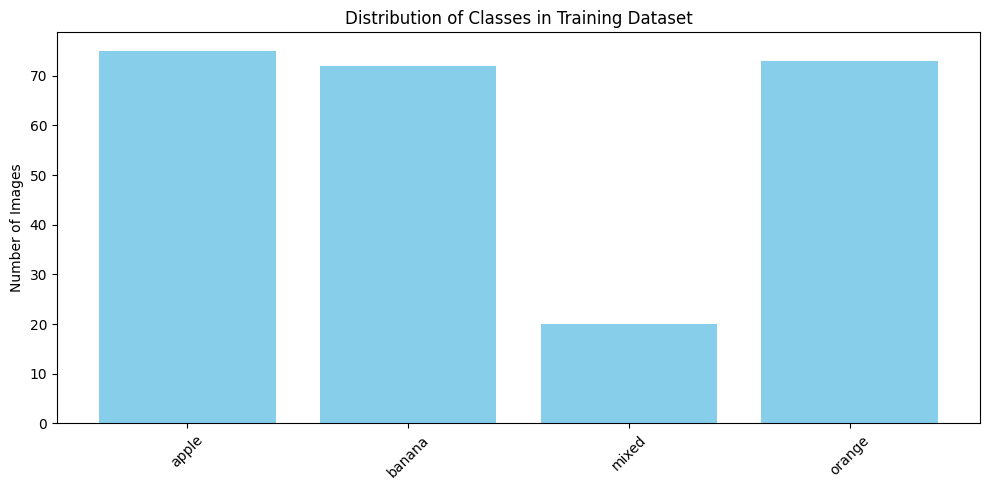

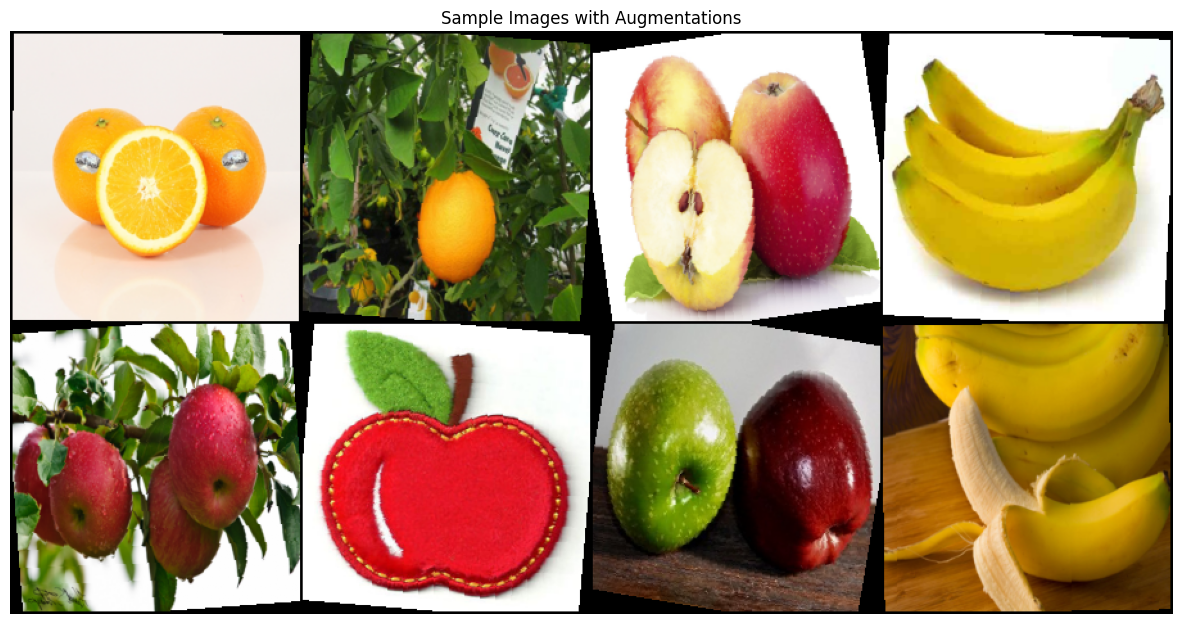

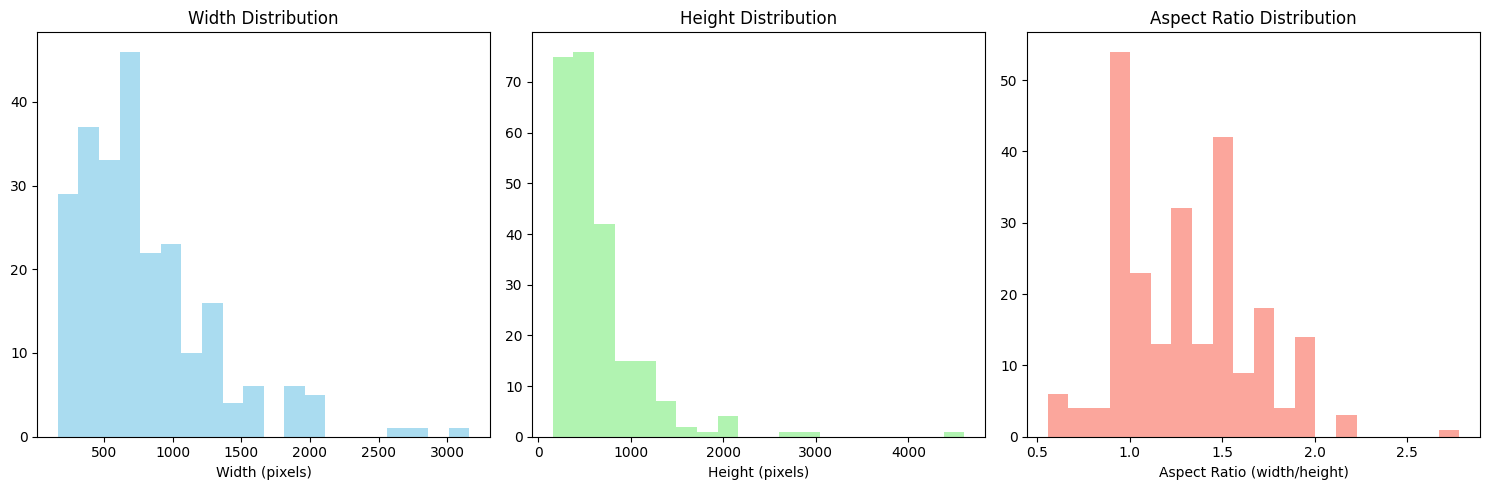


Dataset Summary:
Total images: 240
Number of classes: 4
Skipped images: 0

Class Distribution:
apple: 75 images (31.2%)
banana: 72 images (30.0%)
mixed: 20 images (8.3%)
orange: 73 images (30.4%)

Image Statistics:
Average width: 789.2 pixels
Average height: 633.5 pixels
Average aspect ratio: 1.32


In [40]:
from PIL import Image

def visualize_dataset_info(train_dataset, class_names, train_loader):
    try:
        # 1. Class Distribution (Original)
        plt.figure(figsize=(10, 5))
        class_counts = [sum(1 for _, label in train_dataset if label == i) for i in range(len(class_names))]
        plt.bar(class_names, class_counts, color='skyblue')
        plt.title('Distribution of Classes in Training Dataset')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # 2. Enhanced Sample Grid with Augmentations
        dataiter = iter(train_loader)
        images, labels = next(dataiter)

        plt.figure(figsize=(15, 8))
        grid_img = make_grid(images[:8], nrow=4, normalize=True)
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.title('Sample Images with Augmentations')
        plt.axis('off')
        plt.show()

        # 3. Image Properties Analysis
        sizes = []
        aspect_ratios = []
        skipped = 0
        for path, _ in train_dataset.samples:
            try:
                with Image.open(path) as img:
                    w, h = img.size
                    sizes.append((w, h))
                    aspect_ratios.append(w/h)
            except Exception as e:
                skipped += 1
                continue

        # Size Distribution
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.hist([s[0] for s in sizes], bins=20, color='skyblue', alpha=0.7)
        plt.title('Width Distribution')
        plt.xlabel('Width (pixels)')

        plt.subplot(132)
        plt.hist([s[1] for s in sizes], bins=20, color='lightgreen', alpha=0.7)
        plt.title('Height Distribution')
        plt.xlabel('Height (pixels)')

        plt.subplot(133)
        plt.hist(aspect_ratios, bins=20, color='salmon', alpha=0.7)
        plt.title('Aspect Ratio Distribution')
        plt.xlabel('Aspect Ratio (width/height)')
        plt.tight_layout()
        plt.show()

        # Print Summary
        print("\nDataset Summary:")
        print(f"Total images: {len(train_dataset)}")
        print(f"Number of classes: {len(class_names)}")
        print(f"Skipped images: {skipped}")
        print("\nClass Distribution:")
        for class_name, count in zip(class_names, class_counts):
            print(f"{class_name}: {count} images ({count/len(train_dataset)*100:.1f}%)")

        print("\nImage Statistics:")
        print(f"Average width: {np.mean([s[0] for s in sizes]):.1f} pixels")
        print(f"Average height: {np.mean([s[1] for s in sizes]):.1f} pixels")
        print(f"Average aspect ratio: {np.mean(aspect_ratios):.2f}")

    except Exception as e:
        print(f"Error in visualization: {e}")

# Call the function
visualize_dataset_info(train_dataset, class_names, train_loader)

## Define the CNN Model

In [41]:
# CNN Model
class FruitClassifier(nn.Module):
    def __init__(self):
        super(FruitClassifier, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64 * (IMG_SIZE // 8) * (IMG_SIZE // 8), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=NUM_CLASSES)  # 4 classes for fruits

        # ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # First convolutional layer
        x = self.conv1(x)    # Convolution
        x = self.relu(x)     # ReLU activation
        x = self.pool(x)     # Max pooling

        # Second convolutional layer
        x = self.conv2(x)    # Convolution
        x = self.relu(x)     # ReLU activation
        x = self.pool(x)     # Max pooling

        # Third convolutional layer
        x = self.conv3(x)    # Convolution
        x = self.relu(x)     # ReLU activation
        x = self.pool(x)     # Max pooling

        # Flatten the feature maps
        x = x.view(-1, 64 * (IMG_SIZE // 8) * (IMG_SIZE // 8))  # Adjusted for IMG_SIZE

        # Fully connected layers
        x = self.fc1(x)      # Fully connected layer 1
        x = self.relu(x)     # ReLU activation
        x = self.fc2(x)      # Output layer (no activation for raw logits)

        return x

## Define the train one epoch method

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

## Define the validate method

In [48]:
def validate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = len(test_loader.dataset)

    with torch.no_grad():  # Disable gradient computations for validation
        for batch_inputs, batch_labels in test_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

            # Forward pass
            outputs = model(batch_inputs)

            # Compute the loss
            loss = criterion(outputs, batch_labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_preds += torch.sum(preds == batch_labels).item()

    val_loss = running_loss / len(test_loader)
    val_accuracy = correct_preds / total_samples * 100
    return val_loss, val_accuracy

## Training Loop

In [49]:
# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch + 1}/{NUM_EPOCHS}]")

    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)

    # Validate the model
    val_loss, val_acc = validate(model, test_loader, criterion)

    # Update learning rate
    scheduler.step(val_loss)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print metrics for this epoch
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/20]
Train Loss: 1.4977, Train Acc: 34.17%
Val Loss: 1.2009, Val Acc: 33.33%

Epoch [2/20]
Train Loss: 1.0176, Train Acc: 62.92%
Val Loss: 0.8439, Val Acc: 68.33%

Epoch [3/20]
Train Loss: 0.6450, Train Acc: 77.92%
Val Loss: 0.5965, Val Acc: 85.00%

Epoch [4/20]
Train Loss: 0.4096, Train Acc: 86.25%
Val Loss: 0.5806, Val Acc: 81.67%

Epoch [5/20]
Train Loss: 0.3404, Train Acc: 85.42%
Val Loss: 0.4222, Val Acc: 85.00%

Epoch [6/20]
Train Loss: 0.2049, Train Acc: 90.42%
Val Loss: 0.3801, Val Acc: 90.00%

Epoch [7/20]
Train Loss: 0.1878, Train Acc: 93.33%
Val Loss: 0.3942, Val Acc: 90.00%

Epoch [8/20]
Train Loss: 0.1242, Train Acc: 95.83%
Val Loss: 0.3840, Val Acc: 86.67%

Epoch [9/20]
Train Loss: 0.0873, Train Acc: 95.83%
Val Loss: 0.4185, Val Acc: 91.67%

Epoch [10/20]
Train Loss: 0.0458, Train Acc: 98.33%
Val Loss: 0.5753, Val Acc: 88.33%

Epoch [11/20]
Train Loss: 0.0417, Train Acc: 99.58%
Val Loss: 0.5263, Val Acc: 88.33%

Epoch [12/20]
Train Loss: 0.0311, Train Acc: 99.17%

KeyboardInterrupt: 

In [46]:
# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch + 1}/{NUM_EPOCHS}]")

    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)

    # Validate the model
    val_loss, val_acc = validate(model, test_loader, criterion)

    # Update learning rate
    scheduler.step(val_loss)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print metrics for this epoch
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/20]


NameError: name 'train_epoch' is not defined